In [1]:
import torch
import pandas as pd
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import matplotlib.pylab as plt
from tqdm.autonotebook import tqdm
from PIL import Image
import yaml
import av2
import numpy
from pathlib import Path
from av2.datasets.motion_forecasting import scenario_serialization
from av2.datasets.motion_forecasting.data_schema import TrackCategory, ObjectType, ObjectState, Track
from av2.map.map_api import ArgoverseStaticMap
from av2.utils.typing import NDArrayFloat, NDArrayInt

from typing import Final, List, Optional, Sequence, Set, Tuple
from tensorboardX import SummaryWriter
from joblib import Parallel, delayed, dump, load

DEVICE = "cuda:1" if torch.cuda.is_available() else "cpu"
DEVICE

'cuda:1'

In [2]:
from enum import Enum, unique

class Curvature(Enum):
    NO_CURVATURE = False
    CURVATURE = True

def state_to_vec(state:ObjectState) -> np.ndarray:
    return np.array([state.position[0], state.position[1], state.heading])

def trace_to_vec(track:Track) -> np.ndarray:
    states = list()
    for state in track.object_states:
        states.append(state_to_vec(state))
    states = np.array(states)
    try:
        assert states.shape == (110,3)
        return states
    except AssertionError as a:
        tqdm.write("ID:{}\tShape:{}".format(track.track_id, states.shape))
        raise a

def get_scenario_id(path:Path):
    return path.stem.split("_")[-1]

def get_map_path(path:Path):
    return path.parents[0] / f"log_map_archive_{get_scenario_id(path)}.json"

def get_tracks_for_path(path:Path):
    tracks = list()
    scene = scenario_serialization.load_argoverse_scenario_parquet(path)
    for track in scene.tracks:
        if track.category == TrackCategory.SCORED_TRACK and track.object_type == ObjectType.VEHICLE and len(track.object_states) == 110:
            tracks.append((track, get_map_path(path)))
    return tracks
        
class AV2MotionPredictionDataset(Dataset):
    def __init__(self, scenario_files, n_jobs=32):
        self.scenario_files = scenario_files
        #self.packed_traces = [self._get_tracks_for_path(path) for path in tqdm(self.scenario_files)]
        self.packed_traces = Parallel(n_jobs=32)(delayed(get_tracks_for_path)(path) for path in tqdm(self.scenario_files))
        self.packed_traces = [item for sublist in self.packed_traces for item in sublist]
        self.maps = [map_path for track, map_path in self.packed_traces]
        self.traces = Parallel(n_jobs=32)(delayed(trace_to_vec)(trace) for trace, path in tqdm(self.packed_traces))
        self.traces = np.array(self.traces)
        del self.packed_traces
    
    def __len__(self):
        return self.traces.shape[0]

    def __getitem__(self, idx):      
        inputs = torch.tensor(self.traces[idx, :50], dtype=torch.float32)
        last_pose = torch.tensor(self.traces[idx, 49], dtype=torch.float32)
        target = torch.tensor(self.traces[idx, 50:], dtype=torch.float32)
        return inputs, last_pose, target

In [3]:
path_to_train_dir = Path('/PIMP/Argoverse2/train')
path_to_test_dir = Path('/PIMP/Argoverse2/test')
path_to_val_dir = Path('/PIMP/Argoverse2/val')
train_scenario_files = list(path_to_train_dir.rglob("*.parquet"))
test_scenario_files = list(path_to_test_dir.rglob("*.parquet"))
val_scenario_files = list(path_to_val_dir.rglob("*.parquet"))

path = train_scenario_files[10]
traces = AV2MotionPredictionDataset._get_tracks_for_path(path)
trace = traces[0]

trace_to_vec(trace).shape

test_dataset = AV2MotionPredictionDataset(test_scenario_files)
print(test_dataset.traces.shape)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=True)

In [4]:
val_dataset = AV2MotionPredictionDataset(val_scenario_files)
print(val_dataset.traces.shape)

  0%|          | 0/25000 [00:00<?, ?it/s]

  0%|          | 0/63554 [00:00<?, ?it/s]

(63554, 110, 3)


In [5]:
val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=True)

In [6]:
train_dataset = AV2MotionPredictionDataset(train_scenario_files)
print(train_dataset.traces.shape)
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)

  0%|          | 0/200000 [00:00<?, ?it/s]

  0%|          | 0/506528 [00:00<?, ?it/s]

(506528, 110, 3)


In [7]:
len(train_dataset)

506528

In [8]:
len(val_dataset)

63554

In [9]:
def bicycle_model_eval(inputs, last_poses):
    # This version takes in an input of dim 5
    BATCHES = inputs.shape[0]
    states = []  # torch.zeros((81, 4))
    L = 0.3302
    TS = 0.1
    X, Y, THETA, V = 0, 1, 2, 3
    state = torch.zeros((BATCHES, 4,))
    state[:,X] = last_poses[:,0]
    state[:,Y] = last_poses[:,1]
    state[:,THETA] = last_poses[:,2]
    state[:,V] = inputs[:,0]
    states.append(state)
    for i in range(1,81):
        # Advance bicycle model
        state = torch.zeros((BATCHES, 4,))
        state[:,X] = states[i-1][:,X] + (TS * states[i-1][:,V] * torch.cos(states[i-1][:,THETA]))
        state[:,Y] = states[i-1][:,Y] + (TS * states[i-1][:,V] * torch.sin(states[i-1][:,THETA]))
        state[:,THETA] = states[i-1][:,THETA] + (TS * (states[i-1][:,V] * torch.tan(inputs[:,1])) / L)
        state[:,V] = states[i-1][:,V] + TS*inputs[:,2]
        states.append(state)
    trace = torch.dstack(states).movedim((0,1,2), (0,2,1))
    trace = trace[:,1:,:3]
    return trace

def custom_loss_func(prediction, target):
    loss = F.smooth_l1_loss(prediction[:,:,:2], target[:,:,:2])
    loss += F.smooth_l1_loss(prediction[:,:,2], target[:,:,2])
    #loss += 10*output[0]**2 if output[0]<0 else 0
    #loss += 2*torch.linalg.norm(output)**2
    return loss

def average_displacement_error(prediction, target):
    loss = torch.linalg.norm(prediction[:,:,:2]-target[:,:,:2], dim=2)
    ade = torch.mean(loss, dim=0)
    return torch.mean(ade)

def final_displacement_error(prediction, target):
    loss = torch.linalg.norm(prediction[:,-1,:2]-target[:,-1,:2], dim=1)
    return torch.mean(loss)

class LSTMPredictorBicycle(nn.Module):
    def __init__(self, input_dim=3, hidden_dim=32, control_outputs=1):
        super(LSTMPredictorBicycle, self).__init__()
        self.hidden_dim = hidden_dim
        self.control_outputs = control_outputs

        # The LSTM takes word embeddings as inputs, and outputs hidden states
        # with dimensionality hidden_dim.
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers=4, batch_first=True)

        # The linear layer that maps from hidden state space to tag space
        self.hidden2output = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim//2),
            nn.ELU(),
            nn.Linear(hidden_dim//2, hidden_dim//2),
            nn.ELU(),
            nn.Linear(hidden_dim//2, hidden_dim//2),
            nn.Linear(hidden_dim//2, 1+control_outputs*2)
        )

    def forward(self, inputs):
        lstm_out, _ = self.lstm(inputs)
        output = self.hidden2output(lstm_out)
        scaled_output = list()
        scaled_output.append(F.softplus(output[:,:,0]))
        for step in range(self.control_outputs):
            scaled_output.append(torch.tanh(output[:,:,(step*2)+1])*np.pi)
            scaled_output.append(output[:,:,(step*2)+2])
        output = torch.dstack(scaled_output)
        return output
    
    def predict(self, inputs, last_poses, horizon=60):
        # Compute LSTM output
        controls = self.forward(inputs)[:, -1]  # Take last prediction
        last_poses = last_poses.to(DEVICE)
        BATCHES = controls.shape[0]
        states = []  # torch.zeros((81, 4))
        L = 3.5
        TS = 0.1
        X, Y, THETA, V = 0, 1, 2, 3
        CDIMS = 2
        state = torch.zeros((BATCHES, 4,), device=DEVICE)
        state[:,X] = last_poses[:,0]
        state[:,Y] = last_poses[:,1]
        state[:,THETA] = last_poses[:,2]
        state[:,V] = controls[:,0]
        states.append(state)
        step_length = horizon//self.control_outputs
        for i in range(1,horizon+1):
            # Advance bicycle model
            step = min((i-1)//step_length, self.control_outputs-1)
            state = torch.zeros((BATCHES, 4,), device=DEVICE)
            state[:,X] = states[i-1][:,X] + (TS * states[i-1][:,V] * torch.cos(states[i-1][:,THETA]))
            state[:,Y] = states[i-1][:,Y] + (TS * states[i-1][:,V] * torch.sin(states[i-1][:,THETA]))
            state[:,THETA] = states[i-1][:,THETA] + (TS * (states[i-1][:,V] * torch.tan(controls[:,(step*CDIMS)+1])) / L)
            state[:,V] = states[i-1][:,V] + TS*controls[:,(step*CDIMS)+2]
            states.append(state)
        trace = torch.dstack(states).movedim((0,1,2), (0,2,1))
        trace = trace[:,1:,:3]
        return trace

In [10]:
60//8

7

In [11]:
_DRIVABLE_AREA_COLOR = "#7A7A7A"
_LANE_SEGMENT_COLOR = "#E0E0E0"
def _plot_static_map_elements(ax:plt.Axes, static_map: ArgoverseStaticMap, show_ped_xings: bool = False) -> None:
    """Plot all static map elements associated with an Argoverse scenario.
    Args:
        static_map: Static map containing elements to be plotted.
        show_ped_xings: Configures whether pedestrian crossings should be plotted.
    """
    # Plot drivable areas
    for drivable_area in static_map.vector_drivable_areas.values():
        _plot_polygons(ax, [drivable_area.xyz], alpha=0.5, color=_DRIVABLE_AREA_COLOR)

    # Plot lane segments
    for lane_segment in static_map.vector_lane_segments.values():
        _plot_polylines(ax,
            [
                lane_segment.left_lane_boundary.xyz,
                lane_segment.right_lane_boundary.xyz,
            ],
            line_width=0.5,
            color=_LANE_SEGMENT_COLOR,
        )

    # Plot pedestrian crossings
    if show_ped_xings:
        for ped_xing in static_map.vector_pedestrian_crossings.values():
            _plot_polylines(ax,[ped_xing.edge1.xyz, ped_xing.edge2.xyz], alpha=1.0, color=_LANE_SEGMENT_COLOR)

def _plot_polylines(
    ax:plt.Axes,
    polylines: Sequence[NDArrayFloat],
    *,
    style: str = "-",
    line_width: float = 1.0,
    alpha: float = 1.0,
    color: str = "r",
) -> None:
    """Plot a group of polylines with the specified config.
    Args:
        polylines: Collection of (N, 2) polylines to plot.
        style: Style of the line to plot (e.g. `-` for solid, `--` for dashed)
        line_width: Desired width for the plotted lines.
        alpha: Desired alpha for the plotted lines.
        color: Desired color for the plotted lines.
    """
    for polyline in polylines:
        ax.plot(polyline[:, 0], polyline[:, 1], style, linewidth=line_width, color=color, alpha=alpha)

def _plot_polygons(ax:plt.Axes, polygons: Sequence[NDArrayFloat], *, alpha: float = 1.0, color: str = "r") -> None:
    """Plot a group of filled polygons with the specified config.
    Args:
        polygons: Collection of polygons specified by (N,2) arrays of vertices.
        alpha: Desired alpha for the polygon fill.
        color: Desired color for the polygon.
    """
    for polygon in polygons:
        ax.fill(polygon[:, 0], polygon[:, 1], color=color, alpha=alpha)



In [12]:
def create_debug_plot(net, dataset:AV2MotionPredictionDataset=val_dataset):
    selection = np.random.choice(len(dataset), size=9).tolist()
    map_paths = [dataset.maps[index] for index in selection]
    inputs, last_poses, targets = train_dataset[selection]
    inputs = inputs.to(DEVICE)
    last_poses = last_poses.to(DEVICE)
    targets = targets.to(DEVICE)
    
    outputs = net.predict(inputs, last_poses).detach().cpu().numpy()
    inputs = inputs.detach().cpu().numpy()
    targets = targets.detach().cpu().numpy()

    fig, axs = plt.subplots(3,3,figsize=(10,10), dpi=300)
    for idx, DATA_IDX in enumerate(selection):
        linput, = axs[idx//3, idx%3].plot(inputs[idx,:,0], inputs[idx,:,1], marker='.', label="Input")
        ltarget, = axs[idx//3, idx%3].plot(targets[idx,:,0], targets[idx,:,1], marker='.', label="Target")
        lpred, = axs[idx//3, idx%3].plot(outputs[idx,:,0], outputs[idx,:,1], marker='x', label="Prediction")
        xlim, ylim = np.average(axs[idx//3, idx%3].get_xlim()), np.average(axs[idx//3, idx%3].get_ylim())
        
        #st_map = ArgoverseStaticMap.from_json(map_paths[idx])
        #_plot_static_map_elements(axs[idx//3, idx%3], st_map, True)
        
        axs[idx//3, idx%3].set(xmargin=3,#xlim=(xlim-2,xlim+2),
                               ymargin=3,#ylim=(ylim-2,ylim+2),
                               aspect=1.0,
                               adjustable='box',
                               yticklabels=[],
                               xticklabels=[]
                              )
        axs[idx//3, idx%3].set_title("{}".format(DATA_IDX))
    fig.suptitle("Randomly Selected Traces")
    fig.legend(handles=[linput, ltarget, lpred])
    return fig, axs

In [13]:
net = LSTMPredictorBicycle()
net.to(DEVICE)
#net.load_state_dict(torch.load("best_simple_bicycle.pt"))
for input, last_pose, target in train_dataloader:
    break;
display(input.shape)
display(last_pose.shape)
display(target.shape)
input = input.to(DEVICE)
last_pose = last_pose.to(DEVICE)
other_outp = net.predict(input, last_pose)
other_outp.shape

torch.Size([32, 50, 3])

torch.Size([32, 3])

torch.Size([32, 60, 3])

torch.Size([32, 60, 3])

0.23722529411315918

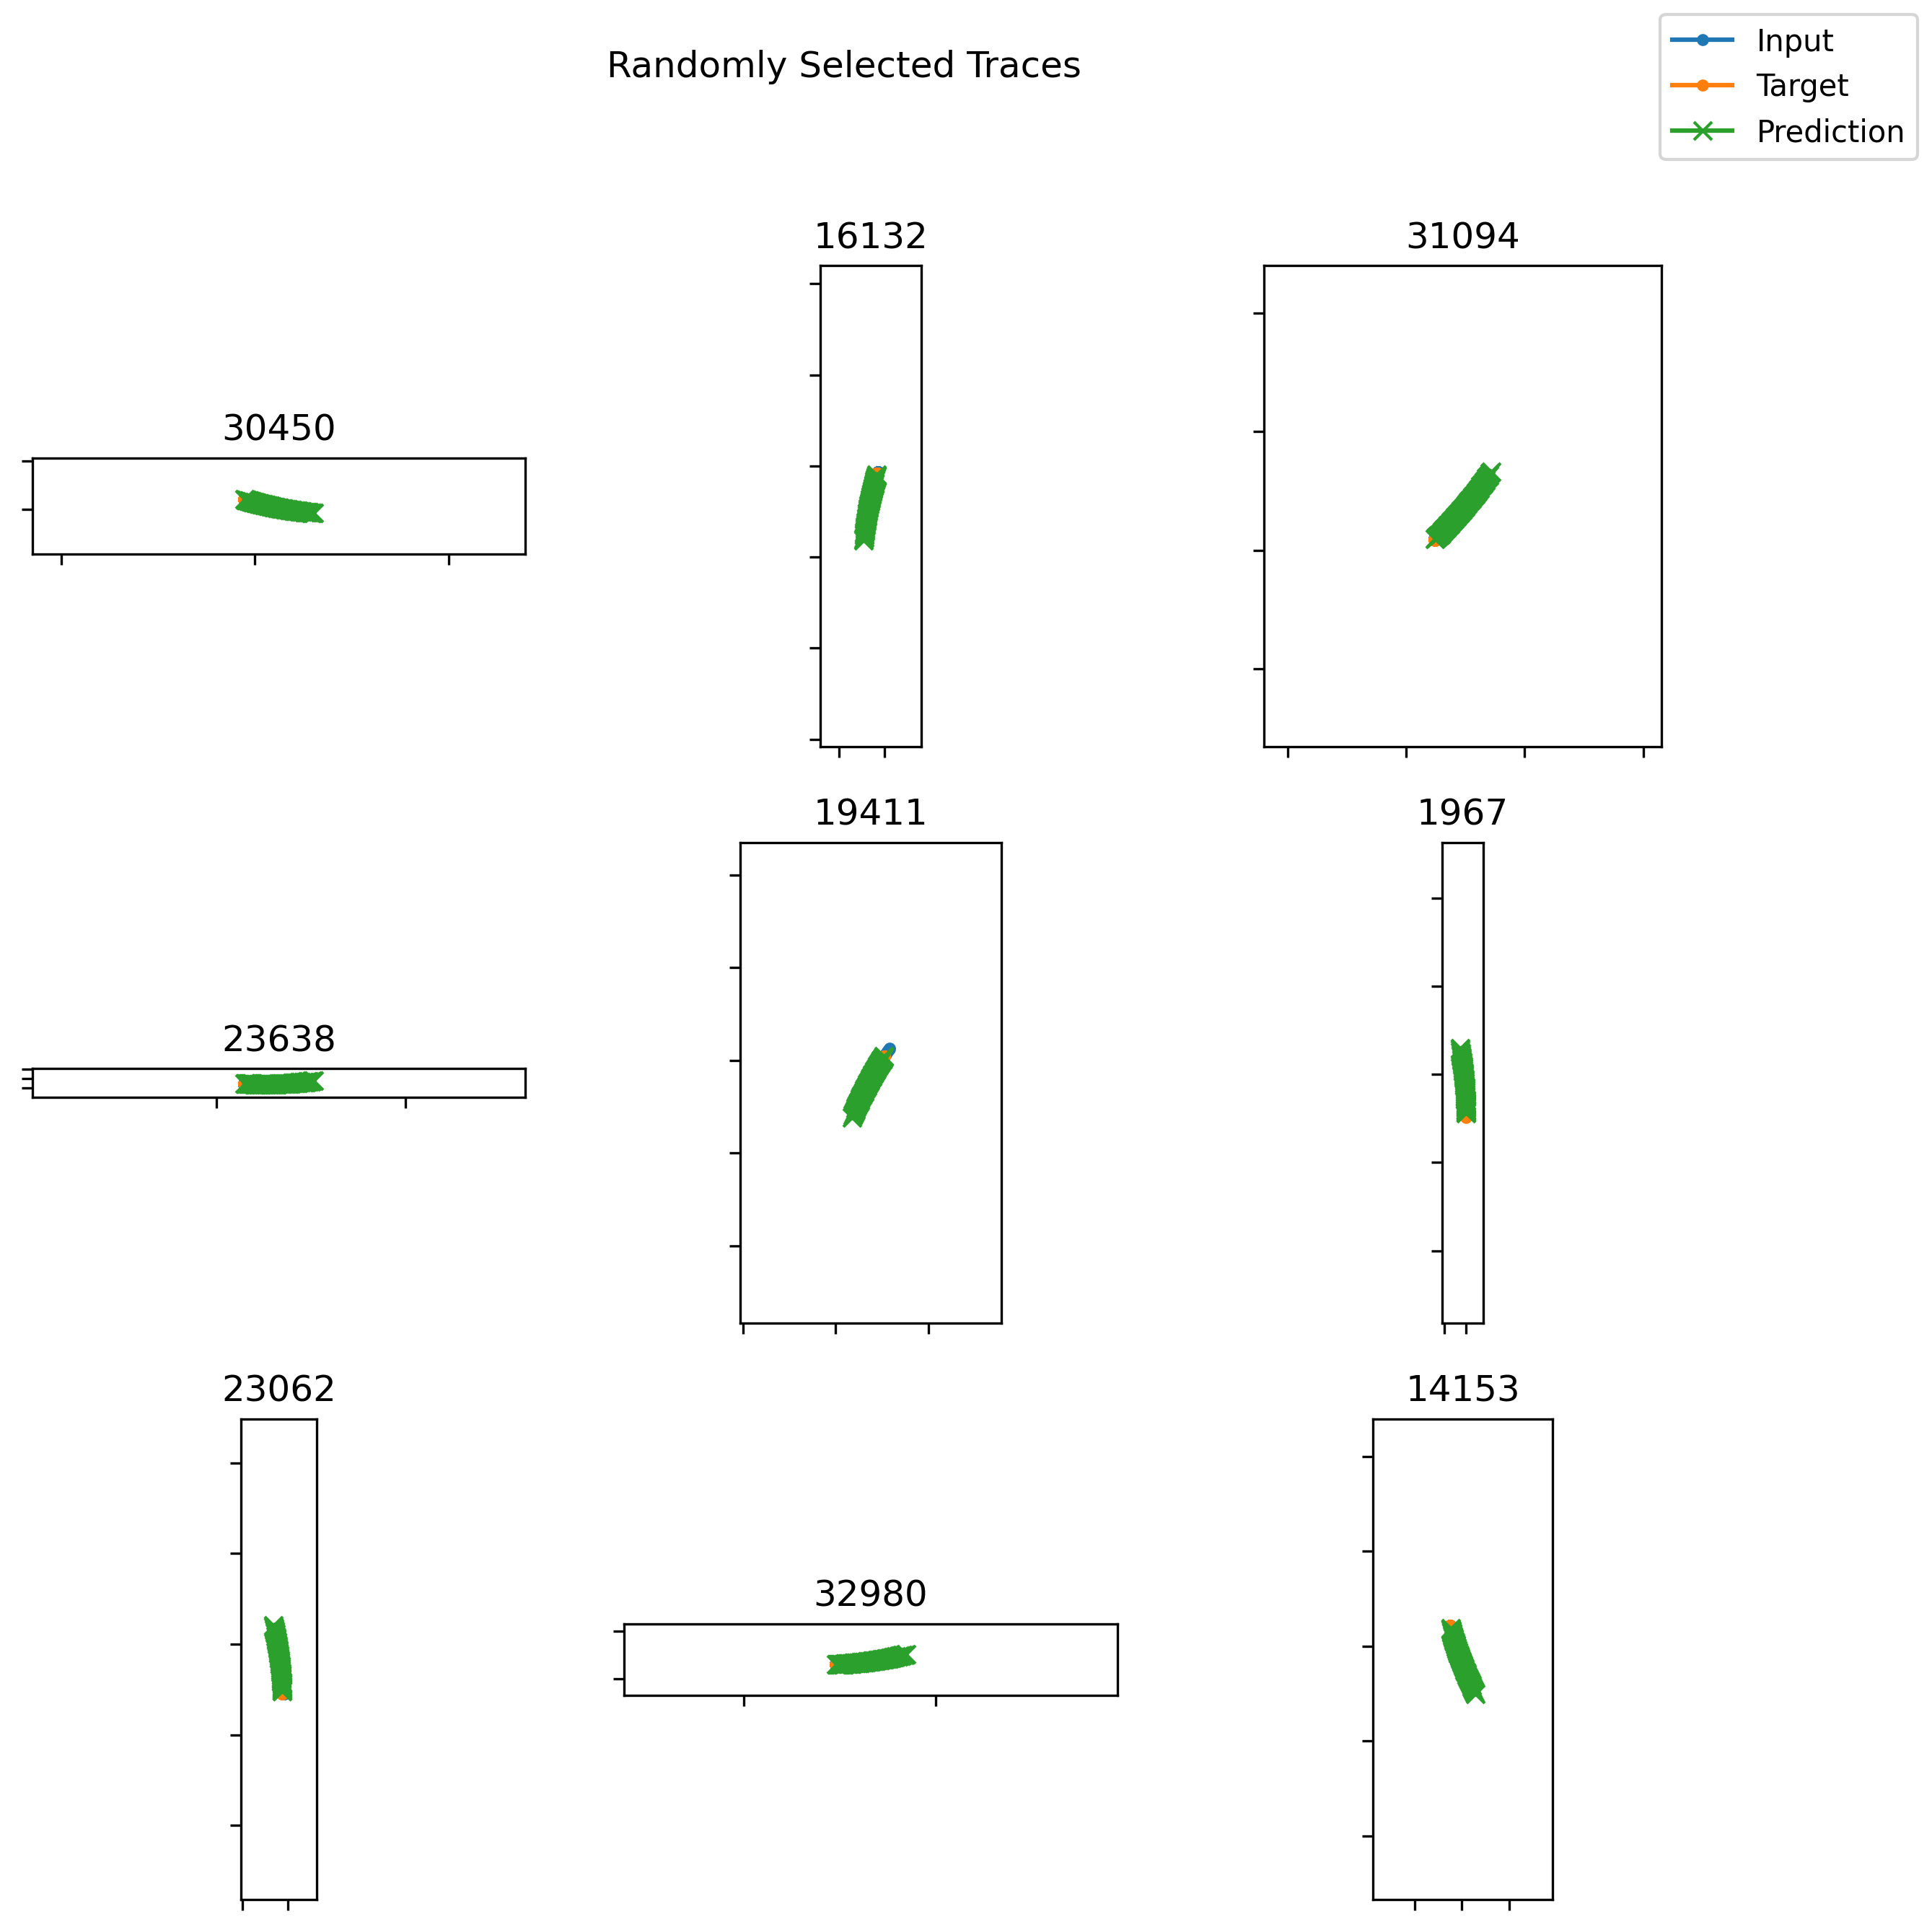

In [14]:
import time
start = time.time()
create_debug_plot(net)
end = time.time()
end-start

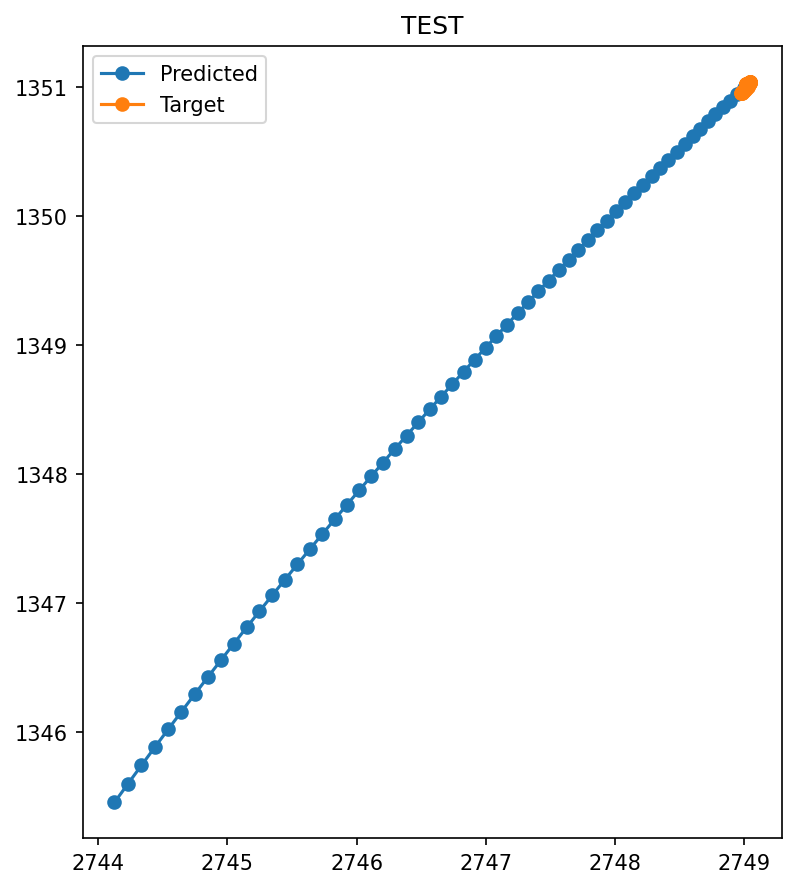

In [15]:
dfig, ax = plt.subplots(figsize=(7,7), dpi=150);
ax.set_aspect(1.0, adjustable='box');
ax.set_title("TEST");
ax.plot(other_outp[0,:,0].cpu().detach().numpy(), other_outp[0,:,1].cpu().detach().numpy(), marker='o', label='Predicted');
ax.plot(target[0,:,0].detach().numpy(), target[0,:,1].detach().numpy(), marker='o', label='Target');
ax.legend();

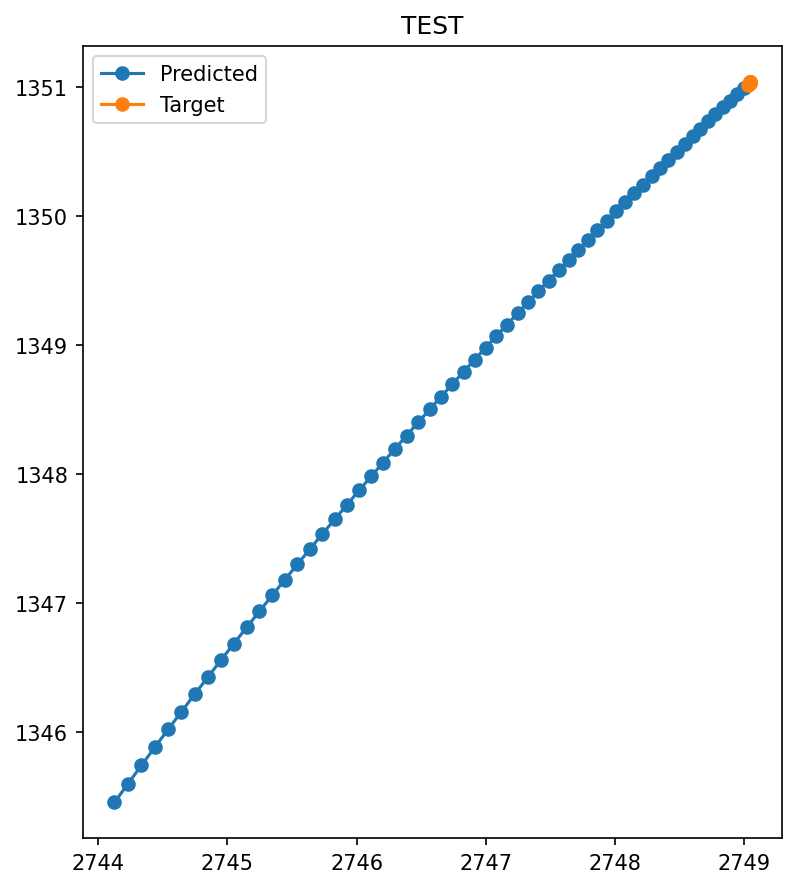

In [16]:
fig, ax = plt.subplots(figsize=(7,7), dpi=150);
ax.set_aspect(1.0, adjustable='box');
ax.set_title("TEST");
ax.plot(other_outp[0,:,0].cpu().detach().numpy(), other_outp[0,:,1].cpu().detach().numpy(), marker='o', label='Predicted')
ax.plot(target[0,:10,0].detach().numpy(), target[0,:10,1].detach().numpy(), marker='o', label='Target')
ax.legend()

In [17]:
def train(control_outputs:int, hidden_dim:int=32, epochs=100):
    directory = f'runs/av2/bicycle-{control_outputs}-{hidden_dim}/'
    writer = SummaryWriter(directory)

    # Training Loop
    torch.autograd.set_detect_anomaly(True)
    net = LSTMPredictorBicycle(input_dim=3,
                               hidden_dim=hidden_dim,
                               control_outputs=control_outputs)
    net.to(DEVICE)
    pytorch_total_params = sum(p.numel() for p in net.parameters())
    optimizer = torch.optim.Adam(net.parameters(), lr=1e-3)
    train_losses = list()
    val_losses = list()
    train_ades, val_ades = list(), list()
    train_fdes, val_fdes = list(), list()

    i=0
    
    for epoch in range(epochs):
        cum_train_loss = 0.0
        net.train()
        fde, ade = list(), list()

        for input_data, last_pose, target_data in tqdm(train_dataloader):
            net.zero_grad()
            input_data = input_data.to(DEVICE)
            last_pose = last_pose.to(DEVICE)
            outp = net.predict(input_data, last_pose)
            target_data = target_data.to(DEVICE)
            loss = custom_loss_func(outp, target_data)
            loss.backward()
            optimizer.step()
            with torch.no_grad():
                fde.append(final_displacement_error(outp, target_data).cpu().numpy())
                ade.append(average_displacement_error(outp, target_data).cpu().numpy())
            cum_train_loss += loss.item()
            
            writer.add_scalar("batch/loss", loss.item(), i)
            writer.add_scalar("batch/ade", ade[-1], i)
            writer.add_scalar("batch/fde", fde[-1], i)
            i+=1

        train_fig, train_ax = create_debug_plot(net, train_dataset)
        cum_train_loss /= len(train_dataset)
        train_losses.append(cum_train_loss)
        ade, fde = np.mean(ade), np.mean(fde)
        writer.add_scalar("ADE/train", ade, epoch)
        writer.add_scalar("FDE/train", fde, epoch)
        train_ades.append(ade)
        train_fdes.append(fde)
        cum_val_loss = 0.0
        fde, ade = list(), list()
        net.eval()
        with torch.no_grad():
            for input_data, last_pose, target_data in tqdm(val_dataloader):
                input_data = input_data.to(DEVICE)
                last_pose = last_pose.to(DEVICE)
                outp = net.predict(input_data, last_pose)
                target_data = target_data.to(DEVICE)
                loss = custom_loss_func(outp, target_data)
                cum_val_loss += loss.item()
                fde.append(final_displacement_error(outp, target_data).cpu().numpy())
                ade.append(average_displacement_error(outp, target_data).cpu().numpy())
            val_fig, val_ax = create_debug_plot(net, val_dataset)
        cum_val_loss /= len(val_dataset)
        val_losses.append(cum_val_loss)
        ade, fde = np.mean(ade), np.mean(fde)
        writer.add_scalar("ADE/val", ade, epoch)
        writer.add_scalar("FDE/val", fde, epoch)
        val_ades.append(ade)
        val_fdes.append(fde)
        if cum_val_loss <= min(val_losses):
            torch.save(net.state_dict(), f"{directory}/best_model.pt")
        writer.add_scalar("loss/train", cum_train_loss, epoch)
        writer.add_scalar("loss/val", cum_val_loss, epoch)
        writer.add_figure("train/example_fig", train_fig, epoch)
        writer.add_figure("val/example_fig", val_fig, epoch)
        tqdm.write(f"Epoch {epoch} | Train Loss: {cum_train_loss} | Val Loss: {cum_val_loss}")
    return {
        'control_outputs': control_ouptut,
        'curvature': curvature,
        'hidden_dims': hidden_dims,
        'training_loss': cum_train_loss,
        'val_loss': cum_val_loss,
        'ade': ade,
        'fde': fde,
        'params': pytorch_total_params
    }

def train_catch(*args, **kwargs):
    import traceback
    try:
        train(*args, **kwargs)
    except Exception as e:
        print("Exception Occurred:")
        print(e)
        traceback.print_exc()
        print("--------------------")
        

In [ ]:
from ray
def train_distributed(config:dict):
    default_config = dict(
        control_outputs=1,
        hidden_dim=32,
        epochs=100
    )
    
    default_config.update(config)
    
    control_ouputs=default_config['control_outputs']
    hidden_dim=default_config['hidden_dim']
    epochs=default_config['epochs']
    
    directory = f'runs/av2/bicycle-{control_outputs}-{hidden_dim}/'
    writer = SummaryWriter(directory)

    # Training Loop
    torch.autograd.set_detect_anomaly(True)
    net = LSTMPredictorBicycle(input_dim=3,
                               hidden_dim=hidden_dim,
                               control_outputs=control_outputs)
    
    net.to(DEVICE)
    pytorch_total_params = sum(p.numel() for p in net.parameters())
    optimizer = torch.optim.Adam(net.parameters(), lr=1e-3)
    train_losses = list()
    val_losses = list()
    train_ades, val_ades = list(), list()
    train_fdes, val_fdes = list(), list()

    i=0
    
    for epoch in range(epochs):
        cum_train_loss = 0.0
        net.train()
        fde, ade = list(), list()

        for input_data, last_pose, target_data in tqdm(train_dataloader):
            net.zero_grad()
            input_data = input_data.to(DEVICE)
            last_pose = last_pose.to(DEVICE)
            outp = net.predict(input_data, last_pose)
            target_data = target_data.to(DEVICE)
            loss = custom_loss_func(outp, target_data)
            loss.backward()
            optimizer.step()
            with torch.no_grad():
                fde.append(final_displacement_error(outp, target_data).cpu().numpy())
                ade.append(average_displacement_error(outp, target_data).cpu().numpy())
            cum_train_loss += loss.item()
            
            writer.add_scalar("batch/loss", loss.item(), i)
            writer.add_scalar("batch/ade", ade[-1], i)
            writer.add_scalar("batch/fde", fde[-1], i)
            i+=1

        train_fig, train_ax = create_debug_plot(net, train_dataset)
        cum_train_loss /= len(train_dataset)
        train_losses.append(cum_train_loss)
        ade, fde = np.mean(ade), np.mean(fde)
        writer.add_scalar("ADE/train", ade, epoch)
        writer.add_scalar("FDE/train", fde, epoch)
        train_ades.append(ade)
        train_fdes.append(fde)
        cum_val_loss = 0.0
        fde, ade = list(), list()
        net.eval()
        with torch.no_grad():
            for input_data, last_pose, target_data in tqdm(val_dataloader):
                input_data = input_data.to(DEVICE)
                last_pose = last_pose.to(DEVICE)
                outp = net.predict(input_data, last_pose)
                target_data = target_data.to(DEVICE)
                loss = custom_loss_func(outp, target_data)
                cum_val_loss += loss.item()
                fde.append(final_displacement_error(outp, target_data).cpu().numpy())
                ade.append(average_displacement_error(outp, target_data).cpu().numpy())
            val_fig, val_ax = create_debug_plot(net, val_dataset)
        cum_val_loss /= len(val_dataset)
        val_losses.append(cum_val_loss)
        ade, fde = np.mean(ade), np.mean(fde)
        writer.add_scalar("ADE/val", ade, epoch)
        writer.add_scalar("FDE/val", fde, epoch)
        val_ades.append(ade)
        val_fdes.append(fde)
        if cum_val_loss <= min(val_losses):
            torch.save(net.state_dict(), f"{directory}/best_model.pt")
        writer.add_scalar("loss/train", cum_train_loss, epoch)
        writer.add_scalar("loss/val", cum_val_loss, epoch)
        writer.add_figure("train/example_fig", train_fig, epoch)
        writer.add_figure("val/example_fig", val_fig, epoch)
        tqdm.write(f"Epoch {epoch} | Train Loss: {cum_train_loss} | Val Loss: {cum_val_loss}")
    return {
        'control_outputs': control_ouptut,
        'curvature': curvature,
        'hidden_dims': hidden_dims,
        'training_loss': cum_train_loss,
        'val_loss': cum_val_loss,
        'ade': ade,
        'fde': fde,
        'params': pytorch_total_params
    }

In [18]:
hyperparameters = {
    'control_outputs': [1,2,4,10,20,30,40,60],
    #'curvature': [Curvature.NO_CURVATURE, Curvature.CURVATURE],
    'hidden_dims': [32, 64],
}
hyp_packages = list()
for control_ouptut in hyperparameters['control_outputs']:
    for hidden_dims in hyperparameters['hidden_dims']:
        hyp_packages.append({
            'control_outputs': control_ouptut,
            'hidden_dims': hidden_dims,})

In [19]:
#train(8, 64, 1)

In [20]:
pytorch_total_params = sum(p.numel() for p in net.parameters())
pytorch_total_params

31203

In [ ]:
from joblib import Parallel, delayed
results = Parallel(n_jobs=2, verbose=1)(delayed(train)(pkg['control_outputs'], pkg['hidden_dims'],5) for pkg in hyp_packages)



[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


In [ ]:
with SummaryWriter('runs/av2') as w:
    for r in results:
        w.add_hparams(
            {
                'control_outputs': r['control_outputs'],
                'hidden_dims': r['hidden_dims'],
                'params': r['params']
            },
            {
                'training_loss': r['training_loss'], 
                'test_loss': r['test_loss'],
                'ade':r['ade'],
                'fde':r['fde']
            }, 
                      name=f"bicycle-{r['control_outputs']}-{r['curvature'].name}-{r['hidden_dim']}")
        